# GLLVM for longitudinal data: a pytorch implementation

We consider the following model

TODO:
* ~~learn the nuisance parameters! To learn phi, make the encoder learn the zhats **before** AR(1) is applied, and take the gradient of the decoder. that is, make the decoder have phi as a parameter, and same for var_mu!~~ 
* ~~allow for gaussian and binary data~~ 
* ~~Compute the gradient that define the model~~
* allow for missing values and impute them


 ## Model Specification

Let  $y_{i1t},y_{i2t},\ldots,y_{ipt}$  be a set of $p$ response or observed variables at time $t,\ t=1,\ldots,T$ for  individual $i,\ i=1,\ldots,n$. Let $\mathbf{x}_{it}$ be a set of observed $k$-dimensional covariates at time $t,\ t=1,\ldots,T$.

Models for multivariate longitudinal data have to account for the three sources of variability
present in the data, that is (i) cross-sectional associations between the responses at a particular time point, (ii) cross-lagged
associations between different responses at different occasions, and  (iii) the association between repeated measures of the same response
over time. The first source of variability is accounted for
a time-dependent latent variable $z_{i1}, z_{i2},\ldots,z_{iT}$. Modeling the temporal evolution of the latent variable accounts for the cross-lagged associations between different responses over time.
The third source of variability can be accounted for a set of item-specific random effects $\mathbf{u}_{i}=(u_{i1}, \ldots, u_{ip})'$.

According to the GLLVM framework we have

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij}\sigma_{u_j})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known {\it link function}, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the {\it linear predictor},  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$. \vspace{5pt}\\
The dynamics of the latent variable over time is modelled through a non-stationary autoregressive model of first order

\begin{equation*}
z_{it}=\phi z_{i,t-1} + \delta_{it}
\end{equation*}%
where  $z_{i1}\sim N(0,\sigma^2_{1})$ and $\delta_{it}\sim N(0,1)$.  Moreover, we assume the random effects independent of the latent variable and their common distribution $\mathbf{u}_{i}\sim N_p(\mathbf{0}, \boldsymbol I)$.


### Changes I propose:

allow x to depend on time.


## Measurement invariance

The  latent variable $z_{it}$ has to be the same (same meaning) across occasions.
Thus the measurement invariance assumption has to be tested on the data, that is 
all the measurement parameters  are invariant across occasions, that is $$\beta_{0jt}=\beta_{0j} \ \textrm{and } \ \lambda_{jt}=
\lambda_{j},$$ for all $t$, $t=1, \ldots, T$ and for all $j$, $j=1,\ldots, p$.
Under this assumption, the model is more parsimonious  and avoids some possible identification problem that might arise with
increasing the number of time points.

To ensure identification of the model, one necessary condition is that the latent variable has a scale and an origin. %When measurement
%invariance of loadings and intercepts is imposed,
Scale for  $z_{it}$  can be provided either by fixing one loading at a nonzero value or by
fixing the factor variance at a nonzero value. In presence of longitudinal data, the same loading is fixed equal to one at each occasion.


## Fast prototyping using Pytorch

We model each observation as a tuple of dimension `(T, p)`, common across individuals. Individuals constitute independent observations, which yields the tensor structure `(n, T, q)`. The time dimension `T` appears in the first dimension since it allows for seamless tensor products of the type `(n, T, q) (q, p)`.

We need

* A model that defines the generative process
* A loss function which, upon taking the derivative, re-creates the estimating equations
* A way to compute the latent variables. For now, we will use a neural network. Later, we can implement the real function.


In [50]:
import torch
from torch import nn
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

In [51]:
# Import the preprocessed data
data = np.load("../data/HRS/HRS_3Darray.npy")

### Loading data
The data has been pre-processed as a 3D array with dimensions given by $(n, k+p, T)$.

The final array is a 3D array of shape (n, k+p, T), where 
* n is the number of observations, 
* k is the number of covariates,
* p is the number of responses to be modeled by the latent variables,
* T is the number of time observations

The variables are ordered as follows:

**Covariates**

- age (covariate)
- gender (covariate)
- education (covariate)

**Responses**

- month (binary)
- day (binary)
- year (binary)
- day_week (binary)
- paper (binary)
- cactus (binary)
- president (binary)
- vice_president (binary)
- serie_7 (count)
- backwards (ordinal)
- recall_immediate (count)
- recall_delayed (count)

The binary random variables are modelled conditionally with a logistic regression; the ordinal variables with an ordinal logistic regression; the counts with poisson regression.

The ordinal responses require an intercept for each level, or "cutpoints". In our case, we model this by hard-coding the intercept, but it should be made more general. We assume the effect of the covariates is constant across categories, resulting in a proportional odds model.

We need to split the ordinal "backwards" into variable into two new variables: backwards_1 and backwards_2. The responses become:

**Covariates**

- 0: age (covariate)
- 1: gender (covariate)
- 2: education (covariate)

**Responses**

- 0: month (binary)
- 1: day (binary)
- 2: year (binary)
- 3: day_week (binary)
- 4: paper (binary)
- 5: cactus (binary)
- 6: president (binary)
- 7: vice_president (binary)
- 8: serie_7 (count)
- 9: backwards_1 (dummy)
- 10: backwards_2 (dummy)
- 11: recall_immediate (count)
- 12: recall_delayed (count)

In [52]:
# Create the backwards_1 and backwards_2 dummies:
backwards_1 = (data[:,12]==1)
backwards_2 = (data[:,12, np.newaxis]==2)

# insert them
data[:,12] = backwards_1
data = np.concatenate([data[:,:12], backwards_2, data[:,12:]], axis=1)

np.nanmax(data)

124.0

In [53]:
# Separate covariates and responses, and prepare the torch tensors

data = np.transpose(data, (0,2,1))
data_true = {
    'x': torch.from_numpy(data[:,:,:3]).float(),
    'y': torch.from_numpy(data[:,:,3:]).float()
}

response_types = {
    'binary': [0,1,2,3,4,5,6,7],
    'ordinal': [9, 10],
    'counts': [8, 11, 12]
}

# We define two inverse link functions; one for sampling (the one assumed in the model), and another for computations (the one used to compute gradients)
linkinv_sample = {
    'binary': lambda x: 1/(1+torch.exp(-x)),
    'ordinal': lambda x: 1/(1+torch.exp(-x)),
    'counts': lambda x: torch.exp(x) 
}

linkinv_decoder = {
    'binary': lambda x: 1/(1+torch.exp(-x)),
    'ordinal': lambda x: 1/(1+torch.exp(-x)),
    'counts': lambda x: x # see below remarks for the standardization of the "counts"
}

In [54]:
# The shape must be (n, T, p)

for key, value in data_true.items():
    print(f'shape of {key}: {value.shape}')
    

shape of x: torch.Size([33146, 9, 3])
shape of y: torch.Size([33146, 9, 13])


In [55]:
n = data_true['x'].shape[0]
k = data_true['x'].shape[2]
p = data_true['y'].shape[2]
T = data_true['y'].shape[1]
q = 1

print(f'Data with {n} observations, {k} covariates, {p} responses, {T} time periods, {1} latent variable per time period.')

Data with 33146 observations, 3 covariates, 13 responses, 9 time periods, 1 latent variable per time period.


##  dealing with missing data
We deal with missing data in two ways:

* The missing values are iteratively imputed by their conditional mean.
* To compute the Z, we use the imputed means.
* To compute the parameters, we use the imputed means and estimated Z but *provide the mask* so that the update does not take the missing values into account in the computation of the gradient.


In [56]:
mask = {}

mask['x'] = torch.isnan(data_true['x'])
mask['y'] = torch.isnan(data_true['y'])

data_true['x'][mask['x']] = 0
data_true['y'][mask['y']] = 0



# Data standardization

To improve numerical stability, we transform the counts as $y\to \log(y+1)$. This is reflected in the sampling mechanics. As a result, we use the identity as a link function for the counts.

In [57]:
# Numerical stability issues for poisson data

data_true['x'][:,:,0] = data_true['x'][:,:,0] /100
# For numerical stability, we transform the counts (poisson) as y -> log(y+1)
# This is reflected in our sampling mechanism so we don't introduce a bias
data_true['y'][:,:,response_types['counts']] = torch.log(data_true['y'][:,:,response_types['counts']] + 1)

In [58]:
print(data_true['x'].shape)
print(data_true['y'].shape)

torch.Size([33146, 9, 3])
torch.Size([33146, 9, 13])


In [59]:

DIMENSIONS_Y = (n, T, p) 
DIMENSIONS_X = (n, T, k)
DIMENSIONS_Z = (n, T, q)
DIMENSIONS_U = (n, 1, p)

# TODO: refactor to have a module of two modules: encoder and decoder
class GLLVM_longitudinal():
    def __init__(self):
        self.encoder = Encoder()
        self.decoder = Decoder()

    def encoder_fit(self, x, y, d, u, epochs=100, verbose=False):
        encoder_loss = nn.MSELoss()
        encoder_opt = torch.optim.Adam(self.encoder.parameters())
        for epoch in range(epochs):
            (dhat, uhat) = self.encoder(x, y)
            loss = encoder_loss(dhat, d) + encoder_loss(uhat, u) # TODO: check that it's correct,maybe Z needs to be weighed more than u
            if verbose:
                print(f"\nEpoch {epoch}/{epochs}, loss={loss}")
            loss.backward()
            encoder_opt.step()
            encoder_opt.zero_grad()
        return loss


    def sample(self, n, x=None, u=None, d=None):
        with torch.no_grad():
            """Sample a longitudinal GLLVM, potentially with z, u, and d(elta), and return (x, u, d, y)"""

            if x is None:
                Warning("x was set to None for sampling. This is usually unwanted unless k=0.")
                x = torch.randn((n, T, k))
            if u is None:
                u = torch.randn((n, 1, p))
            if d is None:
                d = torch.randn((n, T, q))

            # for normal responses: eps = torch.randn((n, T, p)) * torch.sqrt(self.decoder.var_y)

            y = self.decoder(x, d, u)
            for response_type, response_id in response_types.items():
                if response_type == "binary":
                    y[:,:,response_id] = torch.bernoulli(y[:,:,response_id])
                elif response_type == "ordinal":
                    y_ordinal = y[:,:,response_id]
                    # draw one uniform for the whole vector
                    random = torch.rand((*y_ordinal.shape[0:2], 1)) 
                    # compare with the cumulative probabilities
                    ordinal = torch.sum(random < y_ordinal, axis=2)
                    ordinal = torch.nn.functional.one_hot(ordinal).squeeze().float()
                    ordinal = ordinal[:,:,1:] # discard the first column of the one_hot encoding, as it is superfluous (as a 0)
                    y[:,:,response_id] = ordinal
                elif response_type == "counts":
                    y[:,:,response_id] = torch.log(torch.poisson(torch.exp(y[:,:,response_id]))+1) # here we transform the mean using the inverse link - this is due to the transformation of the poisson variable intot a "gaussin". For sampling, we actually want the gaussian.
                     
            return {"x":x, "u":u, "d":d, "y":y}
    
    def impute(self, x, y, mask, nsteps=10):
        """ Impute the missing values provided by the mask (True is missing) and return x imputed"""
        for _ in range(nsteps):
            d, u = self.encoder(x,y)
            y_decoded = self.decoder(x,d,u)
            y[mask] = y_decoded[mask]
        return y
        

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # decoder part (our parameters of interest)
        self.wz = nn.Parameter(torch.randn((q, p)))/10
        self.wx = nn.Parameter(torch.randn((T, k, p)))/10
        self.bias = nn.Parameter(torch.zeros((1, T, p)))/10
        self.phi = nn.Parameter(torch.ones(1))

        # nuisance parameters
        self.var_u = nn.Parameter(torch.ones((1,1,p)))
        self.var_y = nn.Parameter(torch.ones((1,1,p))) # this appears in the loss function, but we know all of them to be 1 by design

    # decoding
    def forward(self, x, d, u):
        z = self.AR(d)
        u = u * torch.sqrt(self.var_u)
        xwx = (x.unsqueeze(2) @ self.wx).squeeze() # see section "details of tensorproducts"
        zwz = (z.unsqueeze(2) @ self.wz).squeeze()
        # for the ordinal variables:
        linpar = self.bias + xwx + zwz + u 

        # Apply the inverse link to get the conditional expectation
        yhat  = torch.zeros_like(linpar)
        for response_type, response_id in response_types.items():
            yhat[:,:,response_id] = linkinv_decoder[response_type](linpar[:,:,response_id])
        # Transform the 
        return yhat

    def AR(self, d):
        z = d.clone()

        for t in range(1, z.shape[1]):
            z[:,t] = z[:,t] + z[:, t-1].clone() * self.phi  # we need to clone else the gradient wants to pass through it
        return z

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder part
        # input dimension is T * (p+k)... we buuild a fully connected layer but it isn't necessary 
        # output dimension is T*q  + p (for Z and U, respectively)
        self.enc_model = nn.Sequential(
            nn.Linear(in_features=T*(p+k), out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = 100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features = T*q + p)
        )
    
    def forward(self, x, y):
        xy = torch.cat([x, y], dim=2).flatten(start_dim=1)
        zu = self.enc_model(xy)
        return self.split_zu(zu)

    def split_zu(self, du):
        #output dimension of size (T*Z), p
        d, u = torch.split(du, [T*q, p], dim=1)
        d = d.reshape((d.shape[0], T, q))
        u = u.unsqueeze(1)
        return (d, u)

In [60]:
gl_true = GLLVM_longitudinal()
dat_sample = gl_true.sample(n, x=data_true['x'])


In [61]:
data_true['y']

tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 1.6094, 1.3863],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 1.3863, 1.3863],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 1.7918, 2.0794],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.0000, 1.9459, 1.9459],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 1.7918, 1.9459],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 1.7918, 1.7918],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.0794, 1.7918],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 2.0794, 1.9459],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 2.0794, 1.

In [62]:
model = GLLVM_longitudinal()

with torch.no_grad():
    model.decoder.phi *= .8
    model.decoder.var_y *= 1.1
    model.decoder.var_u *=.8

In [63]:
def my_loss(input, target, var_y, mask, sign=1):
    #return sign * torch.sum(input*target / torch.sqrt(var_y), dim=[1,2]).mean()
    return sign * torch.sum((input*target / torch.sqrt(var_y)) * mask)/torch.sum(torch.logical_not(mask)) + torch.log(var_y).mean()

def evaluate_fit(input, target, mask):
    with torch.no_grad():
        return torch.sum(torch.pow((input - target)*mask,2))/torch.sum(~mask)
    
class OneLoss(nn.Module):
    def __init__(self):
        super(OneLoss, self).__init__()
    
    def forward(self, y, yhat, ys, yshat, mask):
        """Computes the loss. hat is recontructed y, ys is simulated"""
        loss_sample = torch.sum(y * yhat * mask) / torch.sum(~mask)
        loss_simulated = torch.sum(ys *  yshat * mask) / torch.sum(~mask)

        return loss_sample - loss_simulated


In [64]:
dat_sim = model.sample(n, x=data_true["x"]) # x are known and fixed
# train the encoder on a first pass
model.encoder_fit(dat_sim["x"], dat_sim["y"], dat_sim["d"], dat_sim["u"], epochs=20)


tensor(1.8200, grad_fn=<AddBackward0>)

In [65]:
criterion = OneLoss()
learning_rate = 0.001
max_gradient_value = 0.1
optimizer = torch.optim.Adam(model.decoder.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
mseLoss = nn.MSELoss()
epochs = 100

for epoch in range(1, epochs +1):
    optimizer.zero_grad()

    print(torch.min(data_true["y"]))

    # impute and sample
    with torch.no_grad():
        # data_true["y"] = model.impute(data_true["x"], data_true["y"], mask=mask["y"], nsteps=5)
        # simulate data from the current parameter values, Unconditionally (!)
        dat_sim = model.sample(n, x=data_true["x"])
        # compute the imputing values without the gradients
        dhat_sample, uhat_sample = model.encoder(data_true["x"], data_true["y"])
        dhat_sim, uhat_sim = model.encoder(dat_sim["x"], dat_sim["y"])

    # train the encoder 
    encoder_loss = model.encoder_fit(dat_sim["x"], dat_sim["y"], dat_sim["d"], dat_sim["u"], epochs= 10 ) 
    
    # compute the decoded value
    yhat = model.decoder(data_true["x"], dhat_sample, uhat_sample)
    yshat = model.decoder(dat_sim["x"], dhat_sim, uhat_sim)

    # compute the loss
    loss = criterion(yhat, data_true["y"],  yshat, dat_sim["y"], mask["y"])

    loss.backward(retain_graph=True) # we need to retain it because the loss function requires 2 passes through the decoder.. TODO: ACTUALLY THIS IS NOT THE BEHVAIOR I WANT, 
    with torch.no_grad():   
        fit = mseLoss(yhat, data_true["y"])

    torch.nn.utils.clip_grad_norm_(model.decoder.parameters(), max_norm=.1)
    optimizer.step()
    scheduler.step()

    print(f"\nEpoch {epoch}/{epochs}, loss_fit = {fit.item():.2f}, encoder_loss = {encoder_loss.item():.2f}, phi= {model.decoder.phi.item()}, var_u ={model.decoder.var_u[0,0,0].item()}, var_y={model.decoder.var_y[0,0,0].item()}")

tensor(0.)

Epoch 1/100, loss_fit = 0.40, encoder_loss = 1.72, phi= 0.8009999990463257, var_u =0.8009999990463257, var_y=1.100000023841858
tensor(0.)

Epoch 2/100, loss_fit = 0.37, encoder_loss = 1.68, phi= 0.8019998073577881, var_u =0.8019896745681763, var_y=1.100000023841858
tensor(0.)

Epoch 3/100, loss_fit = 0.36, encoder_loss = 1.62, phi= 0.8029583692550659, var_u =0.8027511835098267, var_y=1.100000023841858
tensor(0.)

Epoch 4/100, loss_fit = 0.35, encoder_loss = 1.58, phi= 0.8039106130599976, var_u =0.8034477233886719, var_y=1.100000023841858
tensor(0.)

Epoch 5/100, loss_fit = 0.35, encoder_loss = 1.54, phi= 0.8048828840255737, var_u =0.8042457699775696, var_y=1.100000023841858
tensor(0.)

Epoch 6/100, loss_fit = 0.34, encoder_loss = 1.51, phi= 0.8058578968048096, var_u =0.8050645589828491, var_y=1.100000023841858
tensor(0.)

Epoch 7/100, loss_fit = 0.33, encoder_loss = 1.48, phi= 0.8068483471870422, var_u =0.8059373497962952, var_y=1.100000023841858
tensor(0.)

Epoch 8/100, lo

KeyboardInterrupt: 

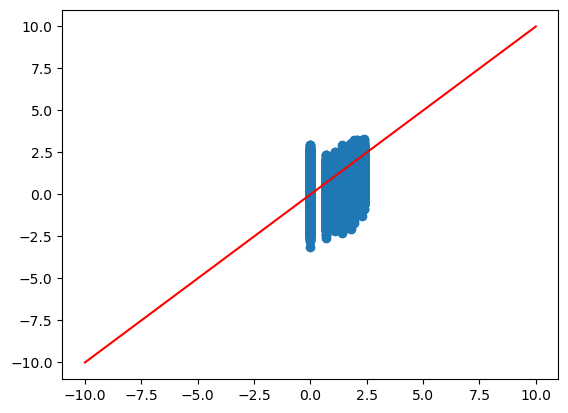

In [ ]:
with torch.no_grad():
    dhat, uhat = model.encoder(data_true["x"], data_true["y"])
    yhat = model.decoder(data_true["x"], dhat, uhat)

plt.scatter(data_true["y"], yhat)
plt.plot([-10, 10], [-10, 10], color="red")
plt.show()

In [ ]:
torch.min(yhat)

tensor(-3.1015)

In [ ]:
dhat = dhat*-1
plt.scatter(dhat, data_true["d"])
plt.plot([-2, 2], [-2,2], color="red")

In [ ]:
# print 12 randomly selected Z
index = np.random.choice(range(n), 12, replace=False)
fig, axs = plt.subplots(3, 4)

zhat= -gl.decoder.AR(dhat).detach()
z_true= gl_true.decoder.AR(data_true["d"]).detach()
fig.suptitle("Ztrue vs Zest across time")
for i in range(12):
    axs[i//4, i%4].plot(zhat[index[i],:,0]*-1)
    axs[i//4, i%4].plot(z_true[index[i],:, 0], color="red")

In [ ]:
par_true = gl_true.decoder.parameters().__next__().detach().squeeze()
par_est = gl.decoder.parameters().__next__() .detach().squeeze()

In [ ]:
plt.scatter(-par_true, par_est)
plt.plot([-2,2], [2, -2])

In [ ]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [ ]:
input

### Details on tensor products calculations
We now show the details on the tensor products, for instance for computing `xb @ wx`. `xb` is of size `(n, T, q)` and `wx` is of size `(T, q, p)`. We want a result of size `(n, T, p)`. First we add a dimension for `xb`:

`xb.unsqueeze(2)` which yields a dimensions of `(n, T, 1, q)`

which we then multiply by `wz`:

`(n, T, 1, q) @ (1, q, p)` -> `(n, T, 1, p)`

where the first dimension of `wx` has been broadcasted.

Finally, we squeeze to obtain `(n, T, p)`.

### Details on the computation of the forward pass

The forward pass depends on $z_{it}$. According to the model, we have

$$z_{i1} \sim N(0,\sigma_z^2).$$

For identifiability reason, we have $z_{i1} = \delta_{i1}$ where $\delta_{i1}\sim N(0,1)$

and then

$$z_{it+1} = \phi z_{it} + \delta{it}$$

$$z_{i2} = \phi \delta_{i1} + \delta_{i1}$$

$$z_{i4} = \phi z_{i3} + \delta_{i3} \Rightarrow z_{i3} = \phi^2 \delta_{i1} + \phi \delta_{i2} + \delta_{i3}$$

$$z_{it+1} = \phi^{t-1}\delta_{i1} + ... + \phi \delta_{it-1} + \delta_{it}$$


So we do not need in-place computations in the forward pass. 
